# ohsome Analyses for HOT Tasking Manager Projects

The following notebook provides a step-by-step introduction and insight into the potential of joint analyses based on the [ohsome API](https://api.ohsome.org) and the [HOT Tasking Manager API](https://tasks.hotosm.org/api-docs/swagger-ui/index.html?url=https://tasks.hotosm.org/api/docs#/). With the example of Nepal, we show you how to extract and to analyse the history of OpenStreetMap. The analyzed HOT Tasking Manager [project 1008](https://tasks.hotosm.org/project/1008) "Nepal Earthquake, 2015, IDP Camps in Kathmandu" was created by [Kathmandu Living Labs](http://www.kathmandulivinglabs.org/) in scope of the [Nepal Earthquake response activation 2015](https://www.hotosm.org/projects/nepal_2015_earthquake_response). 

#### Background of HOT Tasking Manager project 1008: 
In scope of the earthquake, a huge part of the residential buildings in Kathmandu Valley were damaged and no longer safe and habitale due to high risk of collapsing building structures. Therefore, major parts of the population moved to temporal settlements, so-called internally displaced person (IDP) camps, to seek shelter. The purpose of the task was to map the camp locations to support coordination of food, water, and medical care supplies on the ground, and to improve situational awareness.

## 1 Import Python Packages

In [12]:
#The analyses and visualization of results are conducted using Python and relevant libraries

#Import "request" HTTP library to enable easier HTTP handling, see http://docs.python-requests.org/en/master/
import requests

#Import "json" package for encoding and decoding JSON data, see https://docs.python.org/3/library/json.html
import json

#Import "datetime" and "time" module to enable time-related functionalities, see https://docs.python.org/2/library/time.html
import datetime
import time

#Import "panda" library for data manipulation and analysis, see https://pandas.pydata.org/
import pandas as pd
pd.set_option('max_colwidth',100)

#Import "folium" to visualize manipulated data in a Leaflet map, see https://github.com/python-visualization/folium
import folium
from folium.plugins import TimeSliderChoropleth

import IPython
#"IPython display" module import to colormap 
from branca.colormap import linear
from IPython.display import *

## 2 Access Mapping Project Data via HOT Tasking Manager 

First of all, we are interested in receiving project information. Therefore, we start with retrieving the following basic information on the selected project via the [HOT Tasking Manager API](https://tasks.hotosm.org/api-docs/swagger-ui/index.html?url=https://tasks.hotosm.org/api/docs#/):
* **name**: Name of the selected project
* **created**: Information about the project creation date in the HOT Tasking Manager
* **aoiCentroid**: Centroid of the area of interest
* **taskGeometries**: GeoJSON including individual geometries of all mapping tasks in selected project

In [13]:
#Identify project and project id in HOT Tasking Manager and use the latter to request project data
project_id = 1008

#Retrieve relevant project meta data information via HOT Tasking Manager API
project_api_endpoint = f'https://tasking-manager-tm4-production-api.hotosm.org/api/v2/projects/{project_id}'
project_info = requests.get(project_api_endpoint).json()

#Retrieve individual task geometries via HOT Tasking Manager API
tasks_api_endpoint = f'https://tasking-manager-tm4-production-api.hotosm.org/api/v2/projects/{project_id}/tasks'
task_geometries = requests.get(tasks_api_endpoint).json()
project_info['taskGeometries'] = task_geometries

#Display the accessed project information in a table
df = pd.DataFrame.from_dict(project_info, orient='index', columns=['HOT Tasking Manager project information'])
display(df.loc[['projectId','projectInfo','created','taskGeometries'], :])   

,HOT Tasking Manager project information
projectId,1008
projectInfo,"{'locale': 'en', 'name': 'Nepal Earthquake, 2015, IDP Camps in Kathmandu', 'shortDescription': '..."
created,2015-04-27T12:47:37.982338Z
taskGeometries,"{'features': [{'geometry': {'coordinates': [[[[85.2758788909749, 27.7321607050015], [85.28137205..."


## 3 Convert Task Geometries to GeoJSON FeatureCollection

In this interim step, we create a GeoJSON FeatureCollection containing the individual task geometries. If you are happy with aggregated statistics for the overall project extent, you can skip this step and just provide coordinate pairs defining the overall project extent as a list. For more details have a look at the [ohsome API documentation](https://docs.ohsome.org/ohsome-api/stable). 

In [14]:
def project_tasks_to_geojson(project_info):
    geojson = {}
    features = []
    geojson["type"] = "FeatureCollection"
    for task_feature in project_info["taskGeometries"]["features"]:
        features.append({"type": "Feature",
                         "properties": task_feature['properties'],
                         "geometry": task_feature['geometry'],
                         'id': str(task_feature['properties']['taskId'])})
    geojson["features"] = features
    geojson = json.dumps(geojson)
    return geojson

bpolys = project_tasks_to_geojson(project_info)
display('converted task geometries to a GeoJSON FeatureCollection for project: %s.' % project_id)

'converted task geometries to a GeoJSON FeatureCollection for project: 1008.'

## 4 Send Requests to ohsome API

Now we accessed all relevant HOT Tasking Manager data and can focus on the underlying OSM History data. To retrieve history stats from the [ohsome API](https://api.ohsome.org) we first need to build the API request.

#### Part 1: Server Address and API version

An ohsome API request consists of different parts and always needs to start with the address of the server _(https://api.ohsome.org)_ and the API version _(/v1)_. The following parts can be adjusted depending on the current needs and requirements.

#### Part 2: Type of object

The next part of your request needs to specify the type of object that we want to request, for the current API version including the endpoints _/elements_ and _/users_. For our example use case, we will start with _(/elements)_.  

#### Part 3: Aggregation functions

After that, we need to specify the type of aggregation, for instance _count_, _length_, _perimeter_,  _density_ or _area_. In our case, we decided to start with a count, leading to the following request: 'https://api.ohsome.org/v1/elements/count/'.

#### Additional filtering of OSM elements

To furthermore filter the output in sense of temporal, spatial and thematic specifications, we can pass additional parameters. In our case, we chose:

* A spatial filter: In this example, the individual task geometries in GeoJSON format_(bpolys)_.

* A thematic filer: Through the parameter _keys_, we can filter the accessed OSM elements in regard to their OSM tags. In our example we want to retrieve all OSM elements which are marked as IDP Camp, therefore filtering for _(keys=idp:camp_site)_.

* A temporal filter: A time specification can be used to define a specific time period to be requested. E.g. _(time=2015-01-01/2018-04-01/P5D)_ defines a time period of three years, in which results are computed every fifth day _(P5D)_. The time parameter can consist of a timestamp, a time span (with intervals), or a list of timestamps. 

See our defined parameters below:

In [15]:
#Define temporal filter, make sure to use ISO-8601 conform timestrings
start_date = '2015-01-01'
end_date = '2018-04-01'
time_interval = 'P5D' 

#Specified data to be sent to the ohsome API
data = {'bpolys': bpolys,
        'filter': 'idp:camp_site=*',
        'time': f'{start_date}/{end_date}/{time_interval}',
        'showMetadata': 'true'}

### 4.1 ohsome API ― Endpoint: _/elements/count_

To now receive relevant output, we send a POST request to the ohsome API. In this example, we make use of the count function to compute the number of IDP camps in OSM over time. 

### Declaring some helper function:

In [16]:
def elements(agg,**params):
    res = requests.post(OHSOME_API+"/elements"+agg,params)
    return res
def users(agg,**params):
    res = requests.post(OHSOME_API+"/users"+agg,params)
    return res

### Define global constants

In [17]:
OHSOME_API = "https://api.ohsome.org/v1"

'https://api.ohsome.org/v1/elements/count'

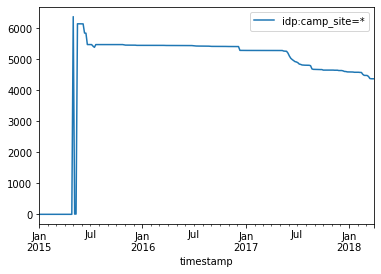

In [18]:
#Send  post request to ohsome api,save response and plot result

def count():
    filter='idp:camp_site=*'
    res = elements("/count"
         ,filter=filter
         ,bpolys=bpolys
         ,time= f'{start_date}/{end_date}/{time_interval}')
    display(res.url)
    body = res.json()
    df = pd.DataFrame(body['result'])
    df.timestamp = pd.to_datetime(df.timestamp)
    df.rename(columns={'value':filter },inplace=True)
    df.set_index('timestamp', inplace=True)
    df.plot()# plotting the result
count()

### 4.2 ohsome API ― Endpoint: _/users/count_

Apart from the OSM elements, we are also interested in learning more about the history stats of OSM data contributors. Therefore, we conduct a count of the number of OSM users that contributed OSM elements that are tagged as IDP camps within the project extent.

'https://api.ohsome.org/v1/users/count'

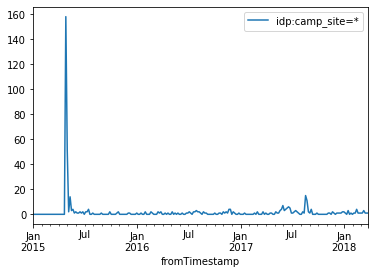

In [19]:
#Send  post request to ohsome api,save response and plot result

def countUsers():
    filter='idp:camp_site=*'
    res = users("/count"
         ,filter=filter
         ,bpolys=bpolys
         ,time= f'{start_date}/{end_date}/{time_interval}')
    display(res.url)
    body = res.json()
    df = pd.DataFrame(body['result'])
    df.fromTimestamp = pd.to_datetime(df.fromTimestamp)
    df.rename(columns={'value':filter },inplace=True)
    df.set_index('fromTimestamp', inplace=True)
    df.plot()# plotting the result
countUsers()


### 4.3 ohsome API ― Endpoint: _/elements/density/groupBy/boundary_

Finally, we would like to retrieve not only aggregated OSM history stats for the entire project extent, but also for the individual tasks. In this case, we use the density function _/density_ to compute the number of IDP camps per sqkm. These get grouped by the task geometries _/groupBy/boundary_.

In [20]:
#Send post request to ohsome API
count_grouby_ohsome = 'https://api.ohsome.org/v1/elements/count/density/groupBy/boundary'
count_groupby = requests.post(count_grouby_ohsome, data=data).json()

#Add response to project info
project_info['osh_stats'] = count_groupby

#Display response
df_count_groupby = pd.DataFrame(count_groupby["groupByResult"]).set_index('groupByObject')
display(df_count_groupby.head(10))

,result
groupByObject,
233,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
234,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
235,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
236,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
229,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
230,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
232,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
69,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."
120,"[{'timestamp': '2015-01-01T00:00:00Z', 'value': 0.0}, {'timestamp': '2015-01-06T00:00:00Z', 'val..."


## 5 Display HOT Tasking Manager Projects on a Web Map

Now let's visualize the mapping efforts in a choropleth map with a time slider using the Folium library. To do so, we need the task geometries (from the HOT Tasking Manager API), which are the zones we would like to represent, and the calculated values for each task geometry (ohsome API).

Play around with the time slider to learn more about the mapping efforts related to the HOT Tasking Manager project 1008 "Nepal Earthquake, 2015, IDP Camps in Kathmandu".

In [21]:
def create_dynamic_choropleth_map(project_info, bpolys, min_value=0, max_value=250):

    # create colormap with given min and max values
    cmap = linear.YlGnBu_09.scale(min_value, max_value)
    cmap.caption = "count IDP camps per sqkm - key=idp:camp_site for HOT project: " + str(project_id)

    # create the style dictionary for each polygon for each timestamp
    styledict = {}
    for task_stats in project_info['osh_stats']['groupByResult']:
        task_id = str(task_stats['groupByObject'])
        styledict[task_id] = {}
        
        for result in task_stats['result']:
            dt = datetime.datetime.strptime(result['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
            unix_timestamp = int(time.mktime(dt.timetuple()))
            value = result['value']
            styledict[task_id][unix_timestamp] = {'color': cmap(value), 'opacity': 0.7}

    # get the location of the centroid to create a
    location = [project_info['aoiBBOX'][1],
                project_info['aoiBBOX'][0]]
    m = folium.Map(tiles='Stamen Toner', location=location, zoom_start=12)
    folium.Marker(location).add_to(m)

    # show choropleth map with time slider
    g = TimeSliderChoropleth(bpolys, styledict=styledict,).add_to(m)

    # add the colorbar legend
    m.add_child(cmap)
    
    return m

# create the colormap, set min and max values
m = create_dynamic_choropleth_map(project_info, bpolys) 

# show map
display(HTML('<h3>Project 1008 - Map</h3> <p>Note: The map does not render in Chrome due to <a href="https://github.com/python-visualization/folium/issues/812">this</a> issue. Please use e.g. Firefox instead.</p>'))
display(m)